In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid") 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import math

In [2]:
msft_hist = pd.read_csv('../dataset/msft_10y.csv', parse_dates=True,index_col=0)

In [3]:
print(msft_hist.isnull().values.any())

False


Text(0.5, 0, 'Year')

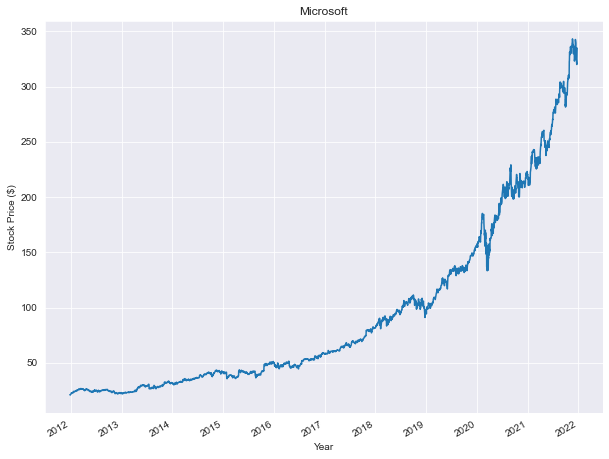

In [4]:

msft_hist['Close'].plot(figsize = (10,8))
plt.title('Microsoft')
plt.ylabel('Stock Price ($)')
plt.xlabel('Year')

In [5]:
msft_close = msft_hist[['Close']]
msft_close.info()
msft_close[['Close']]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2011-12-27 to 2021-12-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


,Close
Date,
2011-12-27,21.076977
2011-12-28,20.898909
2011-12-29,21.060793
2011-12-30,21.012224
2012-01-03,21.667845
...,...
2021-12-17,323.799988
2021-12-20,319.910004
2021-12-21,327.290009


In [6]:
scaler = MinMaxScaler(feature_range= (-1,1))

def split_data(stock, look_back):
    data_raw = stock.to_numpy()
    
    test_size = int(np.round(0.2 * data_raw.shape[0]))
    train_size = data_raw.shape[0] - test_size
    train_set = data_raw[:train_size]
    test_set = data_raw[train_size:]
    train_set_scaled = scaler.fit_transform(train_set)
    test_set_scaled = scaler.transform(test_set)

    train_data = []
    test_data = []

    for i in range(len(train_set_scaled) - look_back):
        train_data.append(train_set_scaled[i: i + look_back])
    train_data = np.array(train_data)

    for i in range(len(test_set_scaled) - look_back):
        test_data.append(test_set_scaled[i: i + look_back])
    test_data = np.array(test_data)

    x_train = train_data[:, :-1, :]
    y_train = train_data[:, -1, :] #every 60th elements affected by previous 59 elements

    x_test = test_data[:, :-1]
    y_test = test_data[:, -1, :]

    return x_train, y_train, x_test, y_test

look_back = 60
x_train, y_train, x_test, y_test = split_data(msft_close, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1953, 59, 1)
y_train.shape =  (1953, 1)
x_test.shape =  (443, 59, 1)
y_test.shape =  (443, 1)


In [7]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [8]:
input_dim = 1
hidden_dim = 32
num_layers = 1
output_dim = 1
num_epochs = 25

In [9]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [10]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
hist = np.zeros(num_epochs)
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)    
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MSE:  0.6454434394836426
Epoch  1 MSE:  0.44554632902145386
Epoch  2 MSE:  0.29494255781173706
Epoch  3 MSE:  0.19102375209331512
Epoch  4 MSE:  0.15598109364509583
Epoch  5 MSE:  0.1727757453918457
Epoch  6 MSE:  0.14870397746562958
Epoch  7 MSE:  0.10499943792819977
Epoch  8 MSE:  0.07673470675945282
Epoch  9 MSE:  0.06530904769897461
Epoch  10 MSE:  0.05994797125458717
Epoch  11 MSE:  0.05143608897924423
Epoch  12 MSE:  0.03609476983547211
Epoch  13 MSE:  0.016713913530111313
Epoch  14 MSE:  0.0029507549479603767
Epoch  15 MSE:  0.0069993180222809315
Epoch  16 MSE:  0.019693469628691673
Epoch  17 MSE:  0.015591710805892944
Epoch  18 MSE:  0.00784805603325367
Epoch  19 MSE:  0.01061426755040884
Epoch  20 MSE:  0.01653076335787773
Epoch  21 MSE:  0.016737526282668114
Epoch  22 MSE:  0.011121771298348904
Epoch  23 MSE:  0.004490530584007502
Epoch  24 MSE:  0.0012336275540292263


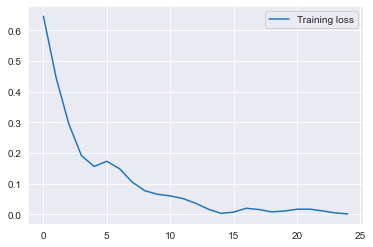

In [12]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [13]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.37 RMSE
Test Score: 39.49 RMSE


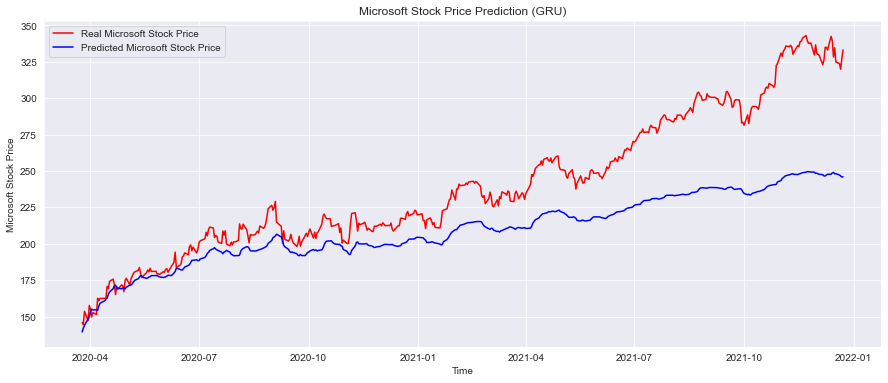

In [14]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(msft_close[len(msft_close)-len(y_test):].index, y_test, color = 'red', label = 'Real Microsoft Stock Price')
axes.plot(msft_close[len(msft_close)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Microsoft Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Microsoft Stock Price Prediction (GRU)')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.show()